## Идеальное решение на основе предыдущих экспериментов

Из ноутбука удалены лишние строки по анализу данных и прошлых экспериментов
чтобы уменьшить время выполнения ноутбука да и вообще самому легче ориентироваться в коротком ноутбуке

Использовать **ImageDataAugmentor** не получилось, постоянно возникали какие-то непонятные ошибки, решил настраивать генерацию руками

In [1]:
#!pip install tensorflow --upgrade
!pip install -q efficientnet

In [55]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import csv
import os
import sys
import zipfile
import shutil

import tensorflow as tf
import efficientnet.tfkeras as efn

import keras as keras
import keras.models
import keras.layers
import keras.backend
import keras.callbacks

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from keras import optimizers
from keras.models import Model, Sequential
from keras.callbacks import Callback, LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from keras.layers import *
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

from tensorflow.python.client import device_lib
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

Python       : 3.7.9 | packaged by conda-forge | (default, Dec  9 2020, 21:08:20) 
Numpy        : 1.19.5
Tensorflow   : 2.4.1
Keras        : 2.4.0


In [56]:
!pip freeze > requirements.txt

In [4]:
!nvidia-smi

Thu Mar 11 15:49:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
device_list = device_lib.list_local_devices()
device_list_GPU = [x.name for x in device_list if 'GPU' in x.name]
print ('GPU подключен') if device_list_GPU else  print('GPU не подключен')

GPU подключен


# Setup

In [57]:
INPUT_PATH  = '../input/sf-dl-car-classification/'
PICTURE_PATH = '/dev/shm/'
MODELS_PATH = '../input/modelases/'
OUTPUT_PATH = '../working/car/'

VALID_SPLIT  = 0.3

In [58]:
os.makedirs(OUTPUT_PATH, exist_ok = True)

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

# EDA / Анализ данных

In [59]:
!rm -d -r '/dev/shm/'
!rm -d -r '../working/car/'
#!rm -d -r '../working/'

rm: cannot remove '/dev/shm/': Device or resource busy


In [60]:
#!unzip '../input/sf-dl-car-classification/train.zip' -d /dev/shm/
#!unzip '../input/sf-dl-car-classification/train.zip' -d '../working/car/'
print('Распаковка картинок')
with zipfile.ZipFile(INPUT_PATH + 'train.zip',"r") as z:
    z.extractall(PICTURE_PATH)
print('Распаковка завершена')    

Распаковка картинок
Распаковка завершена


In [61]:
train_df = pd.read_csv(INPUT_PATH + 'train.csv')

In [62]:
categories = train_df.Category.value_counts()
categories

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

# Data

### Stratify Split

In [63]:
def stratify():
    st = StratifiedShuffleSplit(n_splits = 2, test_size = VALID_SPLIT, random_state = RANDOM_SEED)
    X = train_df['Id']
    y = train_df['Category']
    for train_index, val_index in st.split(X, y):
        train_files, valid_files, train_labels, valid_labels = X[train_index], X[val_index], y[train_index], y[val_index]
        
    #train_files, valid_files, train_labels, valid_labels = \
    #    train_test_split(train_df['Id'], train_df['Category'], 
    #                     test_size = VALID_SPLIT, 
    #                     random_state = RANDOM_SEED, 
    #                    stratify = train_df['Category'])

    train_files = pd.DataFrame(train_files)
    valid_files = pd.DataFrame(valid_files)
    train_files['Category'] = train_labels
    valid_files['Category'] = valid_labels

    print(train_files.shape, valid_files.shape)
    return train_files, valid_files

train_files, valid_files = stratify()

(10892, 2) (4669, 2)


In [64]:
def move_files():
    for cat in categories.index:
        os.makedirs(f'{OUTPUT_PATH}train/{str(cat)}')
        os.makedirs(f'{OUTPUT_PATH}valid/{str(cat)}') 
        
    count_file = 0
    for index, row in train_files.iterrows():
        file_path = 'train/' + str(row['Category']) + '/' + str(row['Id'])
        shutil.move(PICTURE_PATH + file_path, OUTPUT_PATH + file_path)
        count_file += 1
    print(f'move {count_file} train files')
    
    count_file = 0
    for index,row in valid_files.iterrows():
        source_path = 'train/' + str(row['Category']) + '/' + str(row['Id'])
        destination_path = 'valid/' + str(row['Category']) + '/' + str(row['Id'])
        shutil.move(PICTURE_PATH + source_path, OUTPUT_PATH + destination_path)
        count_file += 1
    print(f'move {count_file} valid files')
    
    !rm -d -r '/dev/shm/'
    
move_files()

move 10892 train files
move 4669 valid files
rm: cannot remove '/dev/shm/': Device or resource busy


In [65]:
total = 0
for i in range(0, 10):
    dirr = OUTPUT_PATH + f'train/{i}/'
    count = len([name for name in os.listdir(dirr) if os.path.isfile(os.path.join(dirr, name))])
    print(f'{i} - ', count)
    total += count
print(f'total is train {total}')

total = 0
for i in range(0, 10):
    dirr = OUTPUT_PATH + f'valid/{i}/'
    count = len([name for name in os.listdir(dirr) if os.path.isfile(os.path.join(dirr, name))])
    print(f'{i} - ', count)
    total += count
print(f'total is valid {total}')

0 -  1129
1 -  1380
2 -  1021
3 -  1069
4 -  980
5 -  1142
6 -  1213
7 -  845
8 -  1235
9 -  878
total is train 10892
0 -  484
1 -  591
2 -  437
3 -  459
4 -  420
5 -  489
6 -  520
7 -  362
8 -  530
9 -  377
total is valid 4669


### Data augmentation

In [66]:
# для размера 380 и EfficientNetB4 получаем на последнем этапе ошибку 'OOM when allocating tensor ... by allocator GPU_0_bfc'

In [67]:
EPOCHS       = 7
BATCH_SIZE   = 32
LR           = 1e-3

CLASS_NUM    = 10
IMG_SIZE     = 260
IMG_CHANNELS = 3
input_shape  = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

USE_BIAS     = False
KERNEL_REG   = 'l2'
DROPOUT_RATE = 0.25
STEP_SIZE    = 2

In [68]:
p_rescale = 1. / 255
p_rotation_range = 10
p_zoom_range = 0.15
p_width_shift_range = 0.1
p_height_shift_range = 0.1
p_brightness_range = [0.5, 1.5]
p_shear_range = 0.1

In [69]:
train_datagen = ImageDataGenerator(
    rescale = p_rescale,
    zoom_range = p_zoom_range,
    rotation_range = p_rotation_range,
    width_shift_range = p_width_shift_range,
    height_shift_range = p_height_shift_range,
    shear_range = p_shear_range,
    horizontal_flip = True)

valid_datagen = ImageDataGenerator(
    rescale = p_rescale,
    zoom_range = p_zoom_range,
    rotation_range = p_rotation_range,
    width_shift_range = p_width_shift_range,
    height_shift_range = p_height_shift_range,
    shear_range = p_shear_range,
    horizontal_flip = True)

### datagen

In [70]:
def create_generators():
    train_generator = train_datagen.flow_from_directory(
        OUTPUT_PATH + 'train/',
        target_size = (IMG_SIZE, IMG_SIZE),
        batch_size = BATCH_SIZE,
        class_mode = 'categorical',
        shuffle = True, 
        seed = RANDOM_SEED)

    valid_generator = valid_datagen.flow_from_directory(
        OUTPUT_PATH +'valid/',
        target_size = (IMG_SIZE, IMG_SIZE),
        batch_size = BATCH_SIZE,
        class_mode = 'categorical',
        shuffle = True, 
        seed = RANDOM_SEED)
    return train_generator, valid_generator

train_generator, valid_generator = create_generators()

Found 10892 images belonging to 10 classes.
Found 4669 images belonging to 10 classes.


# Строим модель

In [71]:
#base_model = Xception(weights = 'imagenet', include_top = False, input_shape = input_shape)

In [72]:
# Хуже чем Xception
# base_model = InceptionV3(weights = 'imagenet', include_top = False, input_shape = input_shape)

In [73]:
# Для размера 260 используем EfficientNetB2
# Для размера 380 используем EfficientNetB3
base_model = efn.EfficientNetB2(weights = 'imagenet', include_top = False, input_shape = input_shape)

In [74]:
# Замораживаем веса в базовой модели
base_model.trainable = False

In [75]:
def create_model():
    # Устанавливаем новую "голову" (head)
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D()) # объединяем все признаки в единый вектор 

    model.add(Dense(IMG_SIZE, use_bias = USE_BIAS, kernel_regularizer = KERNEL_REG, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(128, use_bias = USE_BIAS, kernel_regularizer = KERNEL_REG, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))      
    
    model.add(Dense(CLASS_NUM, activation = 'softmax'))
    model.summary()
    
    return model

def create_callbacks():
    checkpoint = ModelCheckpoint('best_model.hdf5', monitor = 'val_accuracy', verbose = 1, mode = 'max', save_best_only = True)
    earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, verbose = 1, patience = 3, restore_best_weights = True)    
    def scheduler(epoch):
        #return LR * (0.75 ** np.floor(epoch / STEP_SIZE))
        return LR * math.pow(math.exp(-0.1), math.floor(epoch / STEP_SIZE))
    lrScheduler = LearningRateScheduler(scheduler, verbose = 1)
    #reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.25, patience = 3, min_lr = 0.0000001, verbose = 1, mode = 'auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=3, verbose=1, mode='auto', epsilon=0.0001)
    
    #tbCallBack = keras.callbacks.TensorBoard(log_dir = OUTPUT_PATH + 'logs/', histogram_freq = 0, write_graph = True, write_images = False)
    
    return [checkpoint, earlystop, lrScheduler]

callbacks_list = create_callbacks()

def build_and_fit_model(need_load = False, step_number = ''):    
    model = create_model()
    model.compile(loss = "categorical_crossentropy", optimizer = optimizers.Adam(lr = LR, amsgrad = True), metrics = ["accuracy"])       
    if need_load:
        history = None
        model.load_weights(MODELS_PATH + f'best_model_step_{step_number}.hdf5')
    else:        
        history = model.fit(
            train_generator,
            steps_per_epoch = train_generator.samples//train_generator.batch_size,
            validation_data = valid_generator, 
            validation_steps = valid_generator.samples//valid_generator.batch_size,
            epochs = EPOCHS,
            verbose = 1,
            callbacks = callbacks_list)
    return history, model

In [76]:
history, model = build_and_fit_model(False, step_number = '1')

model.save('../working/model_step_1.hdf5')

model.load_weights('best_model.hdf5')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b2 (Functional) (None, 9, 9, 1408)        7768562   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1408)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 260)               366080    
_________________________________________________________________
batch_normalization_15 (Batc (None, 260)               1040      
_________________________________________________________________
dropout_15 (Dropout)         (None, 260)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               33280     
_________________________________________________________________
batch_normalization_16 (Batc (None, 128)              

KeyboardInterrupt: 

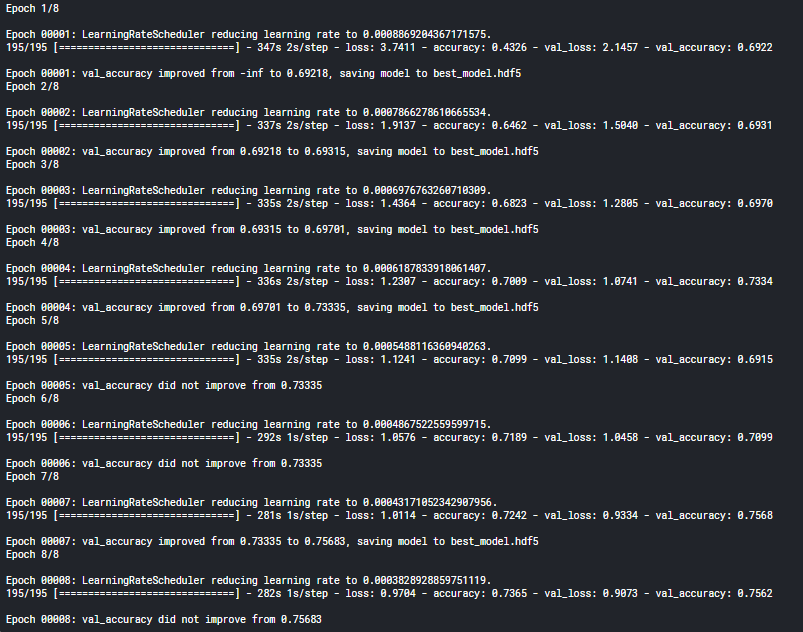

In [ ]:
def calc_scores():
    scores = model.evaluate_generator(valid_generator, steps = len(valid_generator), verbose = 1)
    print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
calc_scores()

In [ ]:
def draw_fig():
    if (history is None):
        return
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_fig = range(len(acc))

    plt.plot(epochs_fig, acc, 'g', label = 'Training acc')
    plt.plot(epochs_fig, val_acc, 'r', label = 'Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs_fig, loss, 'g', label = 'Training loss')
    plt.plot(epochs_fig, val_loss, 'r', label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    
draw_fig()

Скорее всего можно увеличить кол-во эпох для первого этапа, потому что идёт стабильный рост.
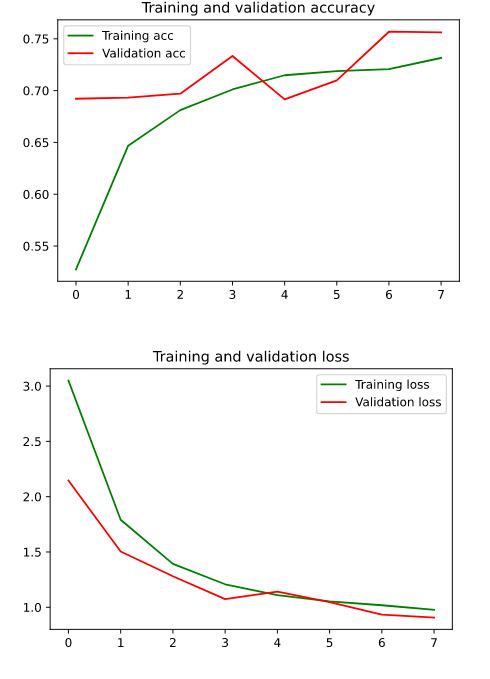

## Этап 2

In [32]:
EPOCHS = 10
LR     = 1e-4

In [33]:
base_model.trainable = True
# Замораживаем половину базовой модели
fine_tune_at = len(base_model.layers) // 2
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [34]:
history, model = build_and_fit_model(False, step_number = '2')

model.save('../working/model_step_2.hdf5')

model.load_weights('best_model.hdf5')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b2 (Functional) (None, 9, 9, 1408)        7768562   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1408)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 260)               366080    
_________________________________________________________________
batch_normalization_5 (Batch (None, 260)               1040      
_________________________________________________________________
dropout_5 (Dropout)          (None, 260)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               33280     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)              

ValueError: Cannot assign to variable block4d_project_conv/kernel:0 due to variable shape (1, 1, 528, 88) and value shape (3, 3, 3, 32) are incompatible

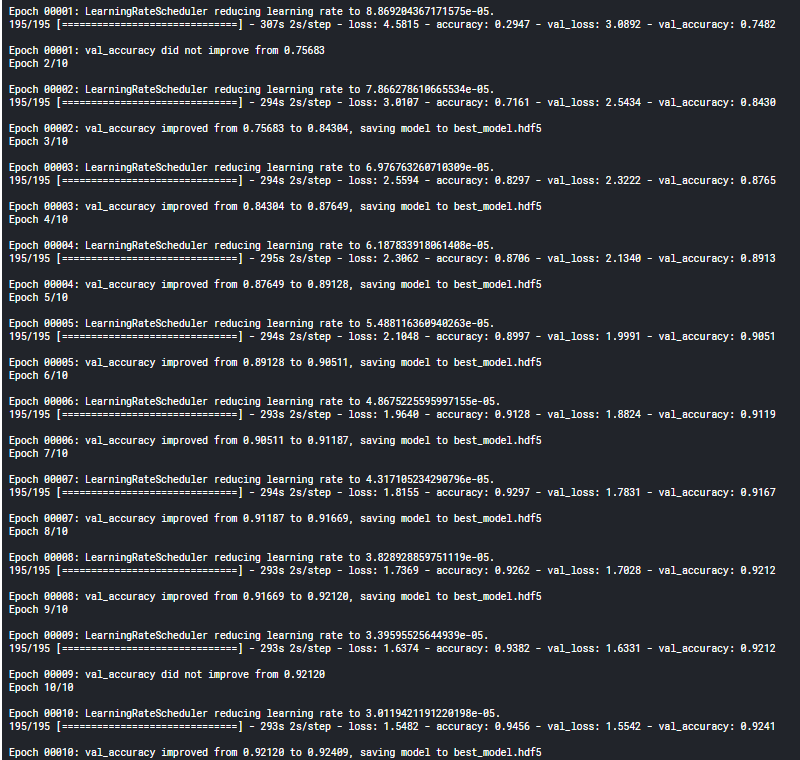

In [ ]:
calc_scores()

In [ ]:
draw_fig()

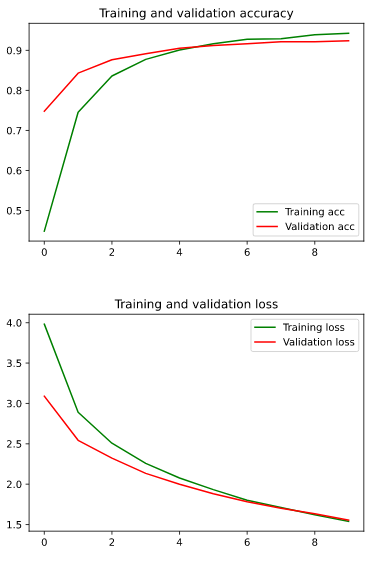

## Этап 3

In [ ]:
EPOCHS       = 12
LR           = 1e-5
STEP_SIZE    = 1

In [ ]:
# Размораживаем всю базовую модель, кроме слоёв нормализации, если всё разморозить, то на выходе получаем плохую точность. Впринципе тоже самое сказано и 
# тут https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

for layer in base_model.layers:
    #if not isinstance(layer, BatchNormalization): 
    layer.trainable = True

In [ ]:
history, model = build_and_fit_model(False, step_number = '3')

model.save('../working/model_step_3.hdf5')

model.load_weights('best_model.hdf5')

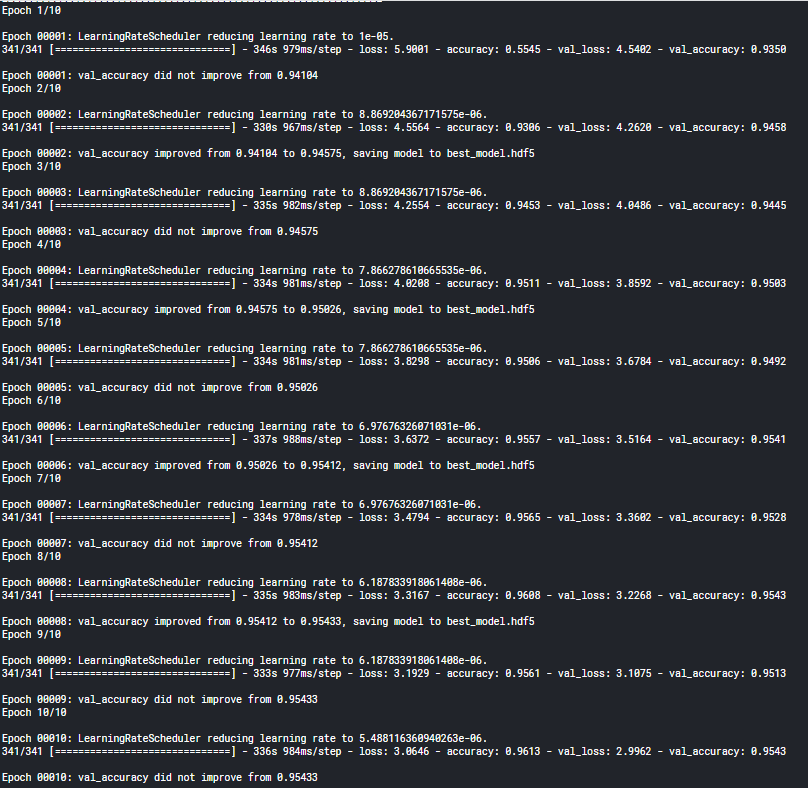

In [ ]:
calc_scores()

In [ ]:
draw_fig()

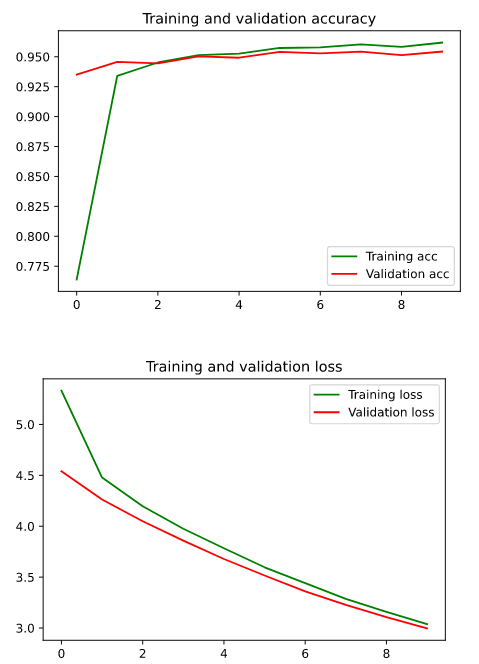

# Submission

In [ ]:
#!unzip '../input/sf-dl-car-classification/test.zip' -d '../working/car/'
print('Распаковка картинок')
with zipfile.ZipFile(INPUT_PATH + 'test.zip',"r") as z:
    z.extractall(OUTPUT_PATH)
print('Распаковка завершена')

In [ ]:
submission_df = pd.read_csv(INPUT_PATH + 'sample-submission.csv')

In [ ]:
def sub():
    test_datagen = ImageDataGenerator(rescale = p_rescale)

    test_generator = test_datagen.flow_from_dataframe(
        dataframe = submission_df,
        directory = OUTPUT_PATH + 'test_upload/',
        x_col = 'Id',
        y_col = None,
        shuffle = False,
        class_mode = None,
        seed = RANDOM_SEED,
        target_size = (IMG_SIZE, IMG_SIZE),
        batch_size = BATCH_SIZE)
    
    test_generator.reset()
    predictions = model.predict_generator(test_generator, steps=len(test_generator), verbose=1) 
    
    predictions = np.argmax(predictions, axis = -1) #multiple categories
    label_map = (train_generator.class_indices)
    label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
    predictions = [label_map[k] for k in predictions]
    
    filenames_with_dir = test_generator.filenames
    submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns = ['Id', 'Category'])
    submission['Id'] = submission['Id'].replace('test_upload/','')
    submission.to_csv('submission.csv', index = False)    
    submission.head()
    print('Save submit')

In [ ]:
def sub_tta():
    test_datagen = ImageDataGenerator(
        rescale = p_rescale,
        zoom_range = p_zoom_range,
        rotation_range = p_rotation_range,
        width_shift_range = p_width_shift_range,
        height_shift_range = p_height_shift_range,
        shear_range = p_shear_range,    
        horizontal_flip = True)

    test_generator = test_datagen.flow_from_dataframe( 
        dataframe = submission_df,
        directory = OUTPUT_PATH + 'test_upload/',
        x_col = "Id",
        y_col = None,
        shuffle = False,
        class_mode = None,
        seed = RANDOM_SEED,
        target_size = (IMG_SIZE, IMG_SIZE),
        batch_size = BATCH_SIZE)
    
    tta_steps = 10
    predictions = []

    for i in range(tta_steps):
        preds = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1) 
        predictions.append(preds)

    pred = np.mean(predictions, axis = 0)
    
    predictions = np.argmax(pred, axis = -1)
    label_map = (train_generator.class_indices)
    label_map = dict((v,k) for k,v in label_map.items())
    predictions = [label_map[k] for k in predictions]
    
    filenames_with_dir = test_generator.filenames
    submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns = ['Id', 'Category'])
    submission['Id'] = submission['Id'].replace('test_upload/','')
    submission.to_csv('submission_TTA.csv', index = False)
    submission.head()
    print('Save submit')

In [ ]:
sub_tta()